# Consumer Expenditure Surveys

> The *Consumer Expenditure Surveys (CE)* program provides data on expenditures, income, and demographic characteristics of consumers in the United States.  
CE data are collected by the Census Bureau for BLS in two surveys, the Interview Survey for major and/or recurring items and the Diary Survey for more minor or frequently purchased items. CE data are primarily used to revise the relative importance of goods and services in the market basket of the Consumer Price Index. The CE is the only Federal household survey to provide information on the complete range of consumers' expenditures and incomes.

## Interview Survey

> The Interview Survey is a rotating panel survey in which approximately 10,000 addresses are contacted each calendar quarter that yield approximately 6,000 useable interviews. One-fourth of the addresses that are contacted each quarter are new to the survey. After a housing unit has been in the sample for four consecutive quarters, it is dropped from the survey, and a new address is selected to replace it.

## Diary Survey

> The Diary Survey is a panel survey in which approximately 5,000 addresses are contacted each calendar quarter that yield approximately 3,000 useable interviews. After a housing unit has been in the sample for two consecutive weeks, it is dropped from the survey, and a new address is selected to replace it.

## Links

[Dataset homepage](https://www.bls.gov/cex/)  
[Micro-data](https://www.bls.gov/cex/pumd_data.htm)  
[Getting started guide](https://www.bls.gov/cex/pumd-getting-started-guide.htm)  
[Data dictionary (XLSX)](https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx)  
[Survey forms](https://www.bls.gov/cex/csxsurveyforms.htm)

[U of Michigan ICPSR](https://www.icpsr.umich.edu/web/ICPSR/series/20) - alternative source of data.

In [1]:
from pathlib import Path
from urllib.parse import urlparse, unquote
from zipfile import ZipFile

import requests
import numpy as np
import pandas as pd

In [3]:
def download_file(url, dir=None, fname=None, overwrite=False):
    """Download file from given `url` and put it into `dir`.
    Current working directory is used as default. Missing directories are created.
    File name from `url` is used as default.
    Return absolute pathlib.Path of the downloaded file."""
    
    if dir is None:
        dir = '.'
    dpath = Path(dir).resolve()
    dpath.mkdir(parents=True, exist_ok=True)

    if fname is None:
        fname = Path(urlparse(url).path).name
    fpath = dpath / fname
    
    if not overwrite and fpath.exists():
        print(f'File {fname} already exists.')
        return fpath

    with requests.get(url) as r:
        r.raise_for_status()
        with open(fpath, 'wb') as f:
            f.write(r.content)
    
    return fpath

def unzip(fpath, dst=None, overwrite=False):
    """Extract all memberfs of Zip archive `fpath` into `dst` directory (current working directory by default)."""
    dst = Path('.' if dst is None else dst)
    with ZipFile(fpath) as zf:
        count = 0
        for member in zf.namelist():
            member_path = dst / member
            if overwrite or not member_path.exists():
                zf.extract(member, dst)
                count += 1
        print(f'Extracted {count} files from {fpath.name}.')

In [ ]:
download_file('https://www.bls.gov/cex/pumd/ce_pumd_interview_diary_dictionary.xlsx', 'data')

for year in range(1980, 2011):
    if year in [1982, 1983]:
        # no survey in these years
        continue
    print(f'Retrieving data for {year}')
    url = 'https://www.bls.gov/cex/pumd/data/comma/intrvw{y2}.zip'.format(y2=str(year)[2:])
    p = download_file(url, 'data/orig')
    unzip(p, p.parent)
    print()

In [3]:
data_dict_vars = pd.read_excel('data/ce_pumd_interview_diary_dictionary.xlsx', 'Variables')

data_dict_codes = pd.read_excel('data/ce_pumd_interview_diary_dictionary.xlsx', 'Codes ')

FMLI questions are asked only once per CU, even though some variable are of quarterly periodicity.

> On the income side, we use the CE measures of total household labor earnings, total household income before tax, and total household income after tax. These variables are reported in the last interview and cover the previous 12 months.

> Each annual data release of the CE PUMD is processed using new data and new disclosure avoidance guidelines. For quarters that appear in two different data releases, an "x" is added to the end of the file name. This "x" is used as an indicator to inform users that the two files were processed under a different set of rules and conditions and therefore the content may differ slightly. It is at the user's discretion as to which file to use.

# Replication example

Aguiar, Mark, and Mark Bils. 2015. “Has Consumption Inequality Mirrored Income Inequality?” American Economic Review 105 (9): 2725–56. https://doi.org/10.1257/aer.20120599.

[Online appendix](https://assets.aeaweb.org/asset-server/articles-attachments/aer/app/10509/20120599_app.pdf)

[Code and data](http://doi.org/10.3886/E112879V1)

Figure 1. Trends in Inequality. Before-tax income line.  
![](aguiar_fig1.png)

Data years: 1980 - 2010

Variables


```
FINCBTAX	Total amount of family income before taxes in the last 12 months (Collected data)
NONINCMX	Total amount of family income other than money receipts before taxes


MISCX4CQ	"Adjusted miscellaneous expenditures this quarter (To be used for population estimates - see information under Summary Expenditure Data heading.) 
MISC1CQ + (4*MISC2CQ)"
MISCX4PQ	Adjusted miscellaneous expenditures last quarter (To be used for population estimates
LIFINSCQ	Life and other personal insurance this quarter
LIFINSPQ	Life and other personal insurance last quarter

```

**Construct before-tax income for each surveyed household**
> Before-tax income in the CE includes labor earnings, non-farm or farm business income, social security and retirement benefits, social security insurance, unemployment benefits, workers’ compensation, welfare (including food stamps), financial income, rental income, alimony and child support, and scholarships. Our measure of before-tax income is that reported in the CE, but we add in food as pay and other money receipts (e.g., gambling winnings). For consistency, as we count receipts of alimony and child support as income, we subtract off payments of alimony and child support. Finally, as rental equivalence is a consumption expenditure for home owners, we include rental equivalence minus out-of-pocket housing costs as part of before-tax income as well.

```sas
/* AB: A LOT is going on in building_dataset/CE/quarterly_and_annual_CE_data.sas,
but here are the key highlights. */

/* READ in FMLY files for 1995 to 2010.  These include spending categories as well as income and demographic variables. */
/* AB: for earlier years, these come from ITAB/MTAB */


O_FINCBTAX=FINCBTAX;
Q_FINC=SUM(0,REQOWN,-OWNDWE,-OWNDW2,-MISCX4,-LIFINS,-ALCHCL,FDMAP); 

/* Deflate annual and quarterly variables. */
ACPI=EXP(LOG(CPI79I{QTR+4}*CPI79I{QTR+3}*CPI79I{QTR+2}*CPI79I{QTR+1})/4);
O_FINCBTAR=O_FINCBTAX/(ACPI/100);
NONINCMR=NONINCMX/(ACPI/100);
ARRAY NCATS{36} ... Q_FINC ...;
ARRAY RCATS{36} ... Q_FINCR ...;
DO I=1 TO 36;
  RCATS{I}=NCATS{I}/(CPI{QTR}/100);
END;


/* Data conseq.famexp2_ND is used below to create the annual data set ANNUAL2_ND */
/* REST OF PROGRAM COMBINES QUARTERS BY ID AND MAKES SAMPLE RESTRICTIONS */


* select just interview 5 observations and rename variables;
DATA FAM5;
  SET conseq.FAMEXP2_ND (
    keep=... O_FINCBTAX Q_FINC Q_FINCR O_FINCBTAR NONINCMX NONINCMR ...
    rename=(... Q_FINC=Q_FINC_5 ... Q_FINCR=Q_FINCR_5)
    where=(intrvw_5=5));
  * Use last interview for annual income-like stuff;
  A_FINCBTAX=SUM(0,O_FINCBTAX,NONINCMX);
  A_FINCBTAR=SUM(0,O_FINCBTAR,NONINCMR);
RUN;

DATA ANNUAL_ND;
  SET ANNUAL;
  *add annual and quarterly components of income variables;
  FINCBTAX=SUM(0,A_FINCBTAX,Q_FINC_2,Q_FINC_3,Q_FINC_4,Q_FINC_5);
  FINCBTAR=SUM(0,A_FINCBTAR,OF Q_FINCR:);
RUN;
```

In [135]:
years = range(1995, 2011)
dfs = []
for year in years:
    y2 = str(year)[2:]
    for quarter in [2, 3, 4, 5]:
        if quarter < 5:
            y2q = f'{y2}{quarter}'
        else:
            y2q = str(year + 1)[2:] + '1'
        if year in [1995, 1998, 2000, 2001]:
            fmli_path = f'data/orig/intrvw{y2}/intrvw{y2}/fmli{y2q}.csv'
        else:
            fmli_path = f'data/orig/intrvw{y2}/fmli{y2q}.csv'
        
        common_cols = ['NONINCMX', 'AGE_REF', 'BLS_URBN', 'FINLWT21']
        if year in [2004, 2005]:
            # only imputed value "FINCBTXM" is available in 2004 and 2005
            # https://www.bls.gov/cex/csximpute.htm
            df = pd.read_csv(fmli_path, usecols=['FINCBTXM', 'FINCBTXI'] + common_cols)
            flag = df['FINCBTXI']
            valid_rows = (flag == 100) | ((flag > 300) & (flag < 400))
            df.loc[valid_rows, 'FINCBTAX'] = df['FINCBTXM']
            df.drop(columns=['FINCBTXM', 'FINCBTXI'], inplace=True)
        else:
            df = pd.read_csv(fmli_path, usecols=['FINCBTAX'] + common_cols)
        df['YEAR'] = year
        df['QUARTER'] = quarter
        dfs.append(df)
df = pd.concat(dfs)
df['A_FINCBTAX'] = df['FINCBTAX'] + df['NONINCMX']
df0 = df

**Select sample**

> CE survey waves from 1981 through 1983 include only urban households, and so for consistency we restrict our analysis to urban residents. Our analysis employs the following further restrictions on the CE urban samples. We restrict households to those with reference persons between the ages of 25 and 64. We only use households who participate in all four interviews, as our income measure and most savings questions are only asked in the final interview. We restrict the sample to those which the CE labels as “complete income reporters,” which corresponds to households with at least one non-zero response to any of the income and benefits questions. We eliminate households that report extremely large expenditure shares on our smaller categories. Finally, to eliminate outliers and mitigate any time-varying impact of top-coding, we exclude households in the top and bottom 5 percent of the before-tax income distribution. (The extent of top coding dictates the 5 percent trimming.) We are left with 62,734 households for 1980–2010. The online data Appendix details how many households are eliminated at each step.

```sas
/* Sample selection to final dataset. */
DATA CONSEQ.ANNUAL2_ND;
  SET ANNUAL_ND;
  IF GROUPM=3 AND WEIRDEXM=0 AND REPS_INM=1 AND FD_INM=1 AND BLS_URBM='1' AND FINCATAX>=0 AND AGEM='25-64';
...
RUN;
/* Create a new sampling weight, NWEIGHT, so that weights sum to one in each year */
PROC SORT DATA=CONSEQ.ANNUAL2_ND;
 BY YEAR;
RUN;
proc means data=CONSEQ.ANNUAL2_ND;
  var finlwt21 ;
  BY YEAR;
  output out=weightv mean=mwght;
run;
data conseq.annual2_ND;
  MERGE CONSEQ.ANNUAL2_ND WEIGHTV;
  BY YEAR;
  NWEIGHT=FINLWT21/MWGHT;
  DROP _TYPE_ _FREQ_ MWGHT;
RUN;


```

In [161]:
df = df0.copy()
# should be (df['A_FINCBTAX'] >= 0), but this leaves so many zeros, esp in some years, so that mean low income is very small and ratio huge
df = df[(df['A_FINCBTAX'] > 0) & df['AGE_REF'].between(25, 64) & (df['BLS_URBN'] == 1)]

**Separate households into before-tax income quintile bins**
> When documenting differences across income levels, we divide households into 5 bins based on before-tax income, with the respective bins containing the 5–20, 20–40, 40–60, 60–80, and 80–95 percentile groups, respectively.

```sas
/* building_dataset/CE/quarterly_and_annual_CE_data.sas */
proc univariate DATA=CONSEQ.ANNUAL2_ND NOPRINT;
  var fincbtar;
  by year;
  weight finlwt21;
  output out=Pctls pctlpts=5 20 40 60 80 95 pctlpre=INC pctlname=P5 P20 P40 P60 P80 P95;
run;
DATA CONSEQ.ANNUAL2_ND;
  MERGE CONSEQ.ANNUAL2_ND PCTLS;
  BY YEAR;
  INCLASS=.;
  IF FINCBTAR>INCP5 AND FINCBTAR<=INCP20 THEN INCLASS=1;
  IF FINCBTAR>INCP20 AND FINCBTAR<=INCP40 THEN INCLASS=2;
  IF FINCBTAR>INCP40 AND FINCBTAR<=INCP60 THEN INCLASS=3;
  IF FINCBTAR>INCP60 AND FINCBTAR<=INCP80 THEN INCLASS=4;
  IF FINCBTAR>INCP80 AND FINCBTAR<=INCP95 THEN INCLASS=5;
  NT_INCLASS=INCLASS;
  IF FINCBTAR NE . AND FINCBTAR<=INCP5 THEN NT_INCLASS=1;
  IF FINCBTAR NE . AND FINCBTAR>INCP95 THEN NT_INCLASS=5;
  DROP INCP5 INCP20 INCP40 INCP60 INCP80 INCP95; 
RUN;
```

In [163]:
# pandas does not have function for weighted quantiles
def wquantile(x, w, q):
    """Return weighted quantiles.
    
    Using 'nearest' as interpolation rule."""
    df = pd.DataFrame({'x': x.copy(), 'w': w.copy()}).sort_values('x').reset_index(False)
#     df.sort_values('x', inplace=True)
    df['w'] /= df['w'].sum()
    df['cw'] = df['w'].cumsum()
    y = []
    for qu in q:
        dif = (df['cw'] - qu).abs()
        qu_idx = dif.argmin()
        y.append(df.at[qu_idx, 'x'])
    return pd.Series(y, index=q)

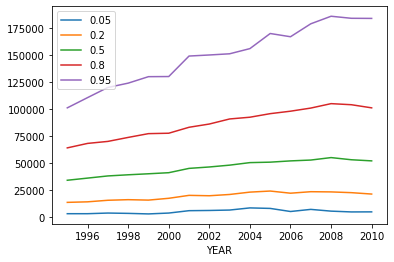

In [168]:
df.groupby('YEAR').apply(lambda d: wquantile(d['A_FINCBTAX'], d['FINLWT21'], [0.05, 0.2, 0.5, 0.8, 0.95])).plot()

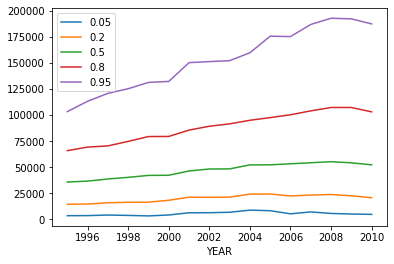

In [133]:
df.groupby('YEAR').A_FINCBTAX.quantile([0.05, 0.2, 0.5, 0.8, 0.95]).unstack().plot()

In [178]:
# quantiles = df.groupby('YEAR')['A_FINCBTAX'].quantile([0, 0.05, 0.2, 0.4, 0.6, 0.8, 0.95, 1])
quantiles = df.groupby('YEAR').apply(lambda d: wquantile(d['A_FINCBTAX'], d['FINLWT21'], [0.05, 0.2, 0.5, 0.8, 0.95])).stack()
df['INCLASS'] = pd.Series(np.nan, dtype=pd.CategoricalDtype(['low', 'high']))
for year in years:
    year_rows = (df['YEAR'] == year)
    low = quantiles[year][[0.05, 0.2]]
    df.loc[year_rows & df['A_FINCBTAX'].between(*low), 'INCLASS'] = 'low'
    high = quantiles[year][[0.8, 0.95]]
    df.loc[year_rows & df['A_FINCBTAX'].between(*high), 'INCLASS'] = 'high'

**Compute average income for each quintile and year**
> For each income group in each year, we average expenditure, income, and savings variables across the member households.

**Compute and plot ratio**
> Our primary measure of inequality is the ratio of the mean of the top income group to the mean of the bottom income group.

> The next line in Figure 1 is for before-tax income which, recall, includes trans- fers. Inequality in this broader measure of income is lower at each point in time, but also shows a steady increase over time. In particular, this ratio increases from 4.75 in 1980–1982 to 6.40 in 2005–2007 (third row of Table 1), for an increase of 30 per- cent over this period.


```stata
/* summary_figures_and_tables.do */
*Figure 1;
preserve; 
local variables fsalaryr fincbtar fincatar totexpr;
collapse `variables' [aw=nweight], by(year inclass);
reshape wide `variables', i(year) j(inclass);
outsheet using "figure1.txt", delim(" ") replace; /*this is read into the tex file directly*/
restore;
```

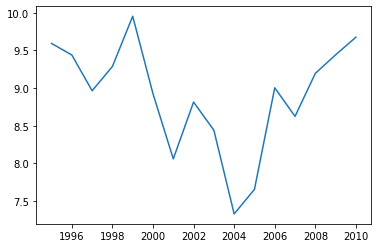

In [181]:
# mean_income = df.groupby(['YEAR', 'INCLASS'])['A_FINCBTAX'].mean()
mean_income = df.groupby(['YEAR', 'INCLASS']).apply(lambda d: np.average(d['A_FINCBTAX'], weights=d['FINLWT21']))
ratio = {}
for year in years:
    ratio[year] = mean_income[(year, 'high')] / mean_income[(year, 'low')]
ratio = pd.Series(ratio)
ratio.plot();

TODO:
- sample restrictions: 
  - GROUPM=3 (all 4 interviews)
  - WEIRDEXM=0 (no expenditure > half income)
  - REPS_INM=1 (complete income reporter for last interview)
  - FD_INM=1 (food expenditures do not exceed total expenditures)
- adjustments from FMLI files (in 1995+): MISCX4, LIFINS, FDMAP
- adjustments from quarterly files (ITAB/MTAB): REQOWN, OWNDWE, ALCHCL and the above before 1995
- 1980-1994
